# Question 1

I’ve marked the most recent ancestor with snakes in green and the most recent ancestor with birds in blue. We can see that, according to the morphological and microRNA evidence, turtles are most closely related to snakes. However, according to the mtDNA and nucDNA evidence, they are more closely related to birds. Here, “more closely related” means their lines diverged more recently.

![](2022-01-13-18-55-58.png)

# Question 2

Humans were an appropriate choice of outgroup for an analysis of birds and turtles because the most recent common ancestor of humans and any bird or reptile is older than the most recent common ancestor between any two organisms from that group. Any mammal would work here, for example, dogs. Crocodiles would be an inappropriate choice because, as shown in the trees above, crocodiles diverged more recently from birds than they did from reptiles.

# Question 3

My guess is that the root was either green or red. There was an initial split where the other color occurred, and that is the earliest split in to evolutionary tree. Then, on the left branch, red and black both emerged independently a few times (an example of homoplasy). On the right side, blue and green both emerged from the red as number of times as well.

Since most of the history of the right branch is unknown, other theories are possible. It would be that the right branch was blue or green and red emerged twice independently on the right branch. If the right branch was initially blue, that would explain why it can be found in two of the subbranches of the right branch: the subbranches containing SUNT and CREN. It seems unlikely that the right branch was black, because this color never appears among lines with known character there.

More broadly, this visualization seems to support the idea that phylogeny and chemical composition are related. However, it seems relatively easy for lines to change chemical composition to fit the needs of the environment.


# Question 4

For this question, we need to find branches that start in India, then move to Sri Lanka, then come back to India. The only phylogeny with well-documented evidence for a single migration of this kind is the crab in figure F. The lines leading from the root to the clade with the families *spiralothelphusa wuellerstorfi*, *spiralothelphusa sp 1*, *oziotelphusa sp 7*, *oziotelphusa sp 6*, *oziotelphusa sp 5* is first brown, then green, then brown. The phylogenic process here is extremely confident; bootstrapping assigns probabilities of 94%+ to every clade containing this one. So, as long as we are confident about the geographic information assigned to ancestor species, then we should be confident that a migration occured.

The fish (figure d) also show evidence of migration, but it is clear that there must have been at least two separate migrations.

# Question 5

In [47]:
bugs = {
    "Escherichia coli": "AACGTTCTAGGCCCATACGG",
    "Bacillus anthracis": "AACGTTCTAGGGCCATACGG",
    "Synechococcus": "AACGTCGTAGGACCATCCGG",
    "Chlorobium": "AACGTCATAGGACCATGCGG",
    "Methanococcus": "ATCGTATAACGTCGATTCGG",
}

def dist(a, b):
    assert len(a) == len(b)
    return sum(x == y for x, y in zip(a, b))/len(a)

print("Distance Matrix\n" + ("-" * 52))
for i, bug in enumerate(bugs):
    distances = [f"{bug:16}"] + ["----" for _ in range(i + 1)]
    for other_bug in list(bugs)[i + 1:]:
        distances.append(dist(bugs[bug], bugs[other_bug]))
    print("\t".join(str(s) for s in distances))


Distance Matrix
----------------------------------------------------
Escherichia coli	----	0.95	0.8	0.8	0.6
Bacillus anthracis	----	----	0.8	0.8	0.6
Synechococcus   	----	----	----	0.9	0.6
Chlorobium      	----	----	----	----	0.6
Methanococcus   	----	----	----	----	----


To build the tree here, I will use [neighbor joining](https://en.wikipedia.org/wiki/Neighbor_joining?oldformat=true).

In [46]:
for node in graph.nodes():
    print(f"{node}: {list(graph.adj[node])}")

0: ['Synechococcus', 'Bacillus anthracis']
Synechococcus: []
Bacillus anthracis: []
1: [0, 'Methanococcus']
Methanococcus: []
2: [1, 'Chlorobium']
Chlorobium: []
3: [2, 'Escherichia coli']
Escherichia coli: []


In [33]:
class DistanceMatrix:
    def __init__(self):
        self._matrix = {}
        self._min_distance = float("inf")
        self._min_edge = None
    
    def set(self, a, b, dist):
        self._matrix[(a, b)] = dist
        self._matrix[(b, a)] = dist
        
        if dist < self._min_distance:
            self._min_distance = dist
            self._min_edge = (a, b)
    
    def get(self, a, b):
        if a == b:
            return 0
        return self._matrix[(a, b)]
    
    def min_edge(self):
        return self._min_edge

In [37]:
import networkx as nx
from itertools import combinations

seqs = bugs

# initialize stuff
u = 0
nodes = set(seqs)
graph = nx.DiGraph()

# calculate distance matrix
distances = DistanceMatrix()
for a, b in combinations(nodes, 2):
    distances.set(a, b, dist(seqs[a], seqs[b]))

for _ in range(len(nodes) - 1):
    n = len(nodes)

    # calculate Q for active nodes
    Q = DistanceMatrix()
    for a, b in combinations(nodes, 2):
        q_ab = (n - 2)*distances.get(a, b) - sum(distances.get(a, k) + distances.get(b, k) for k in nodes)
        Q.set(a, b, q_ab)
    
    # find edge with minimum Q and make new node
    f, g = Q.min_edge()
    dist_fu = 0.5*distances.get(f, g) + (1/(2*(n - 1)))*sum(distances.get(f, k) - distances.get(g, k) for k in nodes)
    dist_gu = distances.get(f, g) - dist_fu
    distances.set(f, u, dist_fu)
    distances.set(g, u, dist_gu)
    graph.add_edge(u, f, weight=dist_fu)
    graph.add_edge(u, g, weight=dist_gu)

    # find distances from u to other nodes
    nodes = nodes - {f, g}
    for k in nodes:
        d_ku = distances.get(f, k) + distances.get(g, k) - distances.get(f, g)
        distances.set(k, u, d_ku)
    nodes.add(u)
    u += 1

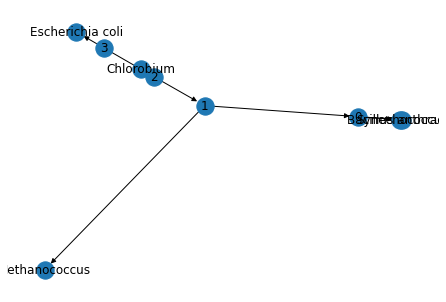

In [41]:
nx.draw_spectral(graph, with_labels=True)

0: ['Synechococcus', 'Bacillus anthracis']
Synechococcus: []
Bacillus anthracis: []
1: [0, 'Methanococcus']
Methanococcus: []
2: [1, 'Chlorobium']
Chlorobium: []
3: [2, 'Escherichia coli']
Escherichia coli: []


In [21]:


def find_two_closest(bugs):
    """find two organisms with most similar sequences"""
    closest = ()
    score = 0
    for a, b in combinations(bugs, 2):
        if (d := dist(bugs[a], bugs[b])) >= score:
            score = d
            closest = (a, b)
    return closest

a, b = find_two_closest(bugs)
a, b

('Escherichia coli', 'Bacillus anthracis')